# AI in Debate Moderation

Ok, this is a wild idea! We can both agree though that sometimes debate moderators don't get it right. Of course, they are human! They can't be 100% right. Maybe they are at 80%. Who knows? If the stakes are really high humans must get extremely close to 100% and they can achieve this with the aid of AI. 

## Contents
- [The Use Case](#The-Use-Case)
- [Success Criteria](#Success-Criteria)
- [AI Solutions](#AI-Solutions)
    - [Out-of-the-box AI](#Out-of-the-box-AI)
    - [End-to-End AI](#End-to-End-AI)
    - [AI with Feature Engineering](#AI-with-Feature-Engineering)
    - [Transfer Learning](#Transfer-Learning)
- [Thoughts](#Thoughts)

## The Use Case

A debate can be a high stakes event. Debate moderators must be impartial and be able to exert control when debaters go out-of-control. Impartiality can be achieved through making sure that the debators are allocated equal time. Controlling debaters who interrupt others can only be achieved through muting the violators. Leaving the task of managing the mute buttons can be too much for the moderator. Comes AI to the rescue!


![agent](images/ai_agent.jpg)

The audio feed of the debate moderator and the debate participants is passed through an AI Agent which decides the channel(s) to output. There are lots of technical details to iron out here but we will focus on how AI can achieve this.

## Success Criteria

1. A metric **talk time** which measures cumulative duration of a debater speaking

     a) Classify speaker based on audio input (Speaker Diarization) with a XX% accuracy
     
     b) Classify interruptions with a XX% accuracy
     
     
2. An output lag of no more than X seconds (Edge Computing will help here but we will not discuss it)

The dynamic control to manage equal allocation of time is left to the moderators and they can take advantage of the metric **talk time** to adjust accordingly. The AI agent can also achieve dynamic control via Reinforcement Learning.

## AI Solutions

It all starts with the data which in this case are audio files and labeled. This enables us to build a model that can achieve speaker diarization. There are advanced models out there but we want to build one, a simple one.

![output](images/output.jpg)

A quick look at the labels tell us this is going to be a multi-label classification. Example 43322 and 43323 show us that we can have multiple speakers in an audio file. We can assume some of these are interruptions.

If we would have one speaker per audio file that would be multi-class classification. 

The difference between these two comes in the output layer of the model. Multi-label will have an output of the same size as the speakers and with the sigmoid activation function. Multi-class will have the softmax activation function. 

### Out-of-the-box AI

This is the go to for general ML tasks, baselines or a quick prototype. I can quickly take advantage of [Google Cloud's Automatic Speech Recognition API](https://cloud.google.com/speech-to-text). There are numerous other solutions out there! 

I also consider AutoML here. You can get a model up and running in an hour! An example will be [Google Cloud's AutoML](https://cloud.google.com/automl).


### End-to-End AI

End-to-end AI is difficult to achieve especially when there is a lot of data and it's unstructured like video, image, audio or text. Computing resources like TPU, GPU and lots of RAM are required. You can always turn to cloud providers of your choice but before you even get there you will need to have a lot of data. Good data! There is not agreed magic number on the size of the training data set but end-to-end is data hungry. Start with several thousands.

![endtoend](images/endtoend.jpg)

Expert knowledge of the domain and the input data required for feature engineering and once this done right, simpler and highly accurate models can be used. 

In [1]:
import IPython.display as ipd
# % pylab inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa

import os
import pathlib


import pandas as pd
import numpy as np
import librosa
import glob 
import librosa.display
import random
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import calibration_curve

import seaborn as sns
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation, Flatten 
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import models

seed = 79
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
print("TF Version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TF Version:  2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DATASET_PATH = 'data/debate'

data_dir = pathlib.Path(DATASET_PATH)

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)

print('Example file tensor:', filenames[0])

Number of total examples: 5704
Example file tensor: tf.Tensor(b'data\\debate\\2198.wav', shape=(), dtype=string)


In [5]:
train_files = filenames[:4564]
val_files = filenames[4564: 4564 + 570]
test_files = filenames[-570:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 4564
Validation set size 570
Test set size 570


In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/433.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([48000, 2])

In [7]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary, desired_channels=1)
  
  return tf.squeeze(audio, axis=-1)


In [8]:
labels = pd.read_csv('data/speaker.csv', dtype = {'File':'int32', 'Biden':'int32','Trump':'int32','Wallace':'int32'})


In [81]:
labels.head()

,File,Biden,Trump,Wallace
0,1,0,0,1
1,2,0,0,1
2,3,0,0,1
3,4,0,0,1
4,5,0,0,1


In [82]:
labels = tf.convert_to_tensor(labels)

In [11]:
labels[1,1:]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1])>

In [12]:
def get_label(file_path):
  key = tf.strings.split(input=file_path, sep=os.path.sep)[-1] 
  key = tf.strings.split(input=key, sep=".")[0]
  key = tf.strings.to_number(key, tf.int32)
  return labels[key-1,1:]

In [13]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  
  return waveform, label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [15]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 48000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [48000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [16]:
for waveform, label in waveform_ds.take(1):
  label = label
  print(label)
  print(waveform.shape)
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
ipd.display(ipd.Audio(waveform, rate=16000))

tf.Tensor([1 0 0], shape=(3,), dtype=int32)
(48000,)
Label: tf.Tensor([1 0 0], shape=(3,), dtype=int32)
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  
  return spectrogram, label

In [18]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = 3

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    tf.keras.
    layers.Dense(num_labels, activation='sigmoid'),
])

model.summary()

Input shape: (374, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [25]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
72/72 [==============================] - 8s 34ms/step - loss: 0.5685 - accuracy: 0.5791 - val_loss: 0.4378 - val_accuracy: 0.7246
Epoch 2/10
72/72 [==============================] - 0s 6ms/step - loss: 0.4333 - accuracy: 0.7386 - val_loss: 0.3662 - val_accuracy: 0.7754
Epoch 3/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3649 - accuracy: 0.7914 - val_loss: 0.3359 - val_accuracy: 0.7930
Epoch 4/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3305 - accuracy: 0.8160 - val_loss: 0.3091 - val_accuracy: 0.8000
Epoch 5/10
72/72 [==============================] - 0s 6ms/step - loss: 0.3033 - accuracy: 0.8311 - val_loss: 0.3044 - val_accuracy: 0.7982
Epoch 6/10
72/72 [==============================] - 0s 6ms/step - loss: 0.2922 - accuracy: 0.8309 - val_loss: 0.3088 - val_accuracy: 0.7930
Epoch 7/10
72/72 [==============================] - 0s 5ms/step - loss: 0.2764 - accuracy: 0.8365 - val_loss: 0.3056 - val_accuracy: 0.8035
Epoch 7: early stop

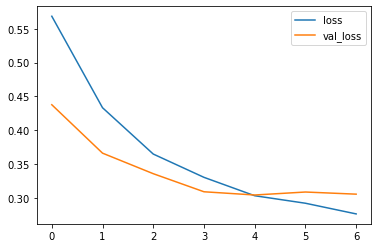

In [26]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [27]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [28]:
THRESHOLD = 0.5

y_pred = model.predict(test_audio)
y_pred = y_pred  > THRESHOLD
y_pred = y_pred.astype(int)
y_pred_flat = y_pred.astype(int).flatten()

y_true = test_labels
y_true_flat = test_labels.flatten()

test_acc = sum(y_pred_flat == y_true_flat) / len(y_true_flat)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 89%


In [31]:
y_true

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [32]:
y_pred

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

In [33]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

array([[[300.,  26.],
        [ 51., 193.]],

       [[301.,  21.],
        [ 26., 222.]],

       [[339.,  38.],
        [ 30., 163.]]], dtype=float32)

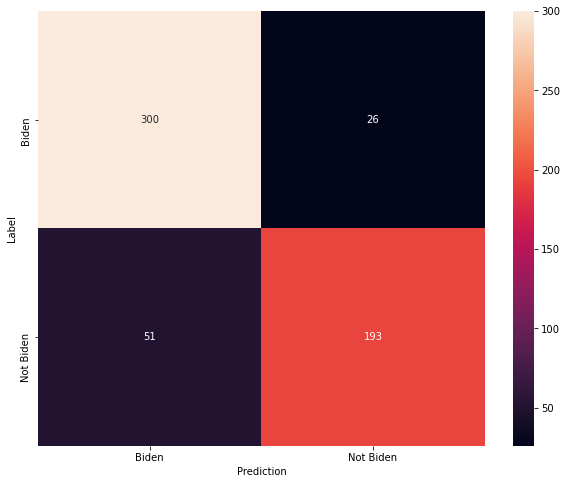

In [34]:
confusion_mtx = result[0]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Biden","Not Biden"],
            yticklabels=["Biden","Not Biden"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

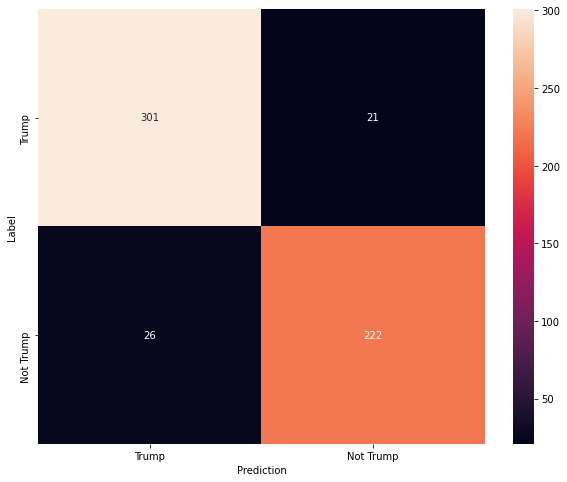

In [35]:
confusion_mtx = result[1]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Trump","Not Trump"],
            yticklabels=["Trump","Not Trump"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

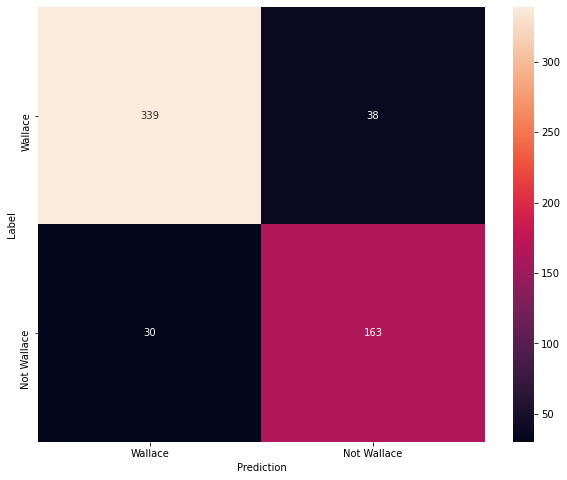

In [36]:
confusion_mtx = result[2]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Wallace","Not Wallace"],
            yticklabels=["Wallace","Not Wallace"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### AI with Feature Engineering

Features engineering falls on a spectrum. It can be as easy as playing with a datetime feature to as complicated as audio signal processing. CNN can do this as part of model for end-to-end AI. In this example we will see audio feature engineering.

In [ ]:
# Fit the multi-label binarizer on the training set
# print("Labels:")
# mlb = MultiLabelBinarizer()
# mlb.fit(y_train)
# transform the targets of the training and test sets
# y_train_bin = mlb.transform(y_train)
# y_val_bin = mlb.transform(y_val)
# Loop over all labels and show them


In [49]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('data/debate')+'/'+str(files.audio_file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    # label = files.lable

    return mfccs, chroma, mel, contrast, tonnetz

In [43]:
voices = os.listdir('data/debate') 
voices = pd.DataFrame(voices, columns=['audio_file'])
voices['file'] = voices['audio_file'].str[:-4].astype('int64')
voices.head()

,audio_file,file
0,1.wav,1
1,10.wav,10
2,100.wav,100
3,1000.wav,1000
4,1001.wav,1001


In [44]:
labels = pd.read_csv('data/speaker.csv', dtype = {'File':'int32', 'Biden':'int32','Trump':'int32','Wallace':'int32'})


In [45]:
labeled_voices = pd.merge(voices, labels, how='inner', left_on='file',right_on='File')

In [46]:
labeled_voices

,audio_file,file,File,Biden,Trump,Wallace
0,1.wav,1,1,0,0,1
1,10.wav,10,10,0,0,1
2,100.wav,100,100,0,0,0
3,1000.wav,1000,1000,1,0,0
4,1001.wav,1001,1001,1,0,0
...,...,...,...,...,...,...
5699,995.wav,995,995,1,0,1
5700,996.wav,996,996,1,0,1
5701,997.wav,997,997,1,0,0
5702,998.wav,998,998,1,0,0


In [131]:
startTime = datetime.now()
features_label = labeled_voices.apply(extract_features, axis=1)
print(datetime.now() - startTime)

In [51]:
features_label

0       ([-316.14893, 142.19208, -28.876055, 26.372023...
1       ([-268.13617, 120.899826, -31.390236, 25.11015...
2       ([-188.92662, 48.207226, -86.547516, -22.70199...
3       ([-373.39462, 52.491207, -10.77176, 63.02623, ...
4       ([-364.55457, 73.53598, -21.008894, 41.02669, ...
                              ...                        
5699    ([-341.50073, 131.39627, -37.78101, 17.855215,...
5700    ([-294.81802, 102.98069, -20.5588, 20.25569, -...
5701    ([-320.38504, 115.801956, -21.924505, 24.16668...
5702    ([-297.01648, 61.988964, -19.845503, 66.33844,...
5703    ([-326.5932, 97.70723, -8.621423, 42.55274, 17...
Length: 5704, dtype: object

In [52]:
features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [53]:
features[0]

array([-3.16148926e+02,  1.42192078e+02, -2.88760548e+01,  2.63720226e+01,
       -3.74285483e+00, -1.55572453e+01, -3.58161583e+01, -4.83183050e+00,
       -2.20243492e+01,  8.05978298e+00, -1.95616837e+01, -5.43646955e+00,
       -1.36732111e+01, -4.21579313e+00, -3.50703835e+00, -3.80577111e+00,
       -1.35622292e+01, -3.11483860e+00, -2.92427731e+00, -9.62712765e+00,
       -1.17938261e+01, -3.82251453e+00, -9.28313446e+00, -4.32293081e+00,
       -5.32484818e+00, -8.78487396e+00, -1.75729740e+00, -7.45111799e+00,
       -9.77463126e-01,  8.39363411e-02, -4.05375338e+00,  8.69719088e-01,
       -3.79887915e+00, -6.49424744e+00, -4.63895655e+00, -1.88436711e+00,
       -3.37211752e+00, -4.37069446e-01,  4.05609369e+00,  6.48762941e+00,
        5.76570094e-01,  4.63275999e-01,  4.84776378e-01,  5.66238463e-01,
        6.33214235e-01,  6.94447696e-01,  5.90347767e-01,  5.81185818e-01,
        5.96771300e-01,  6.48633659e-01,  6.72818661e-01,  6.26591921e-01,
        6.89517008e-04,  

In [54]:
X = np.array(features)

In [55]:
y = labeled_voices[['Biden','Trump','Wallace']].values

In [56]:
#labeled_voices.head()
y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [57]:
scalar = StandardScaler()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=1) 

In [59]:
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

In [63]:
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(8, activation = 'relu'))
model.add(Dropout(0.25))    

model.add(Dense(3, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [64]:
history = model.fit(X_train, y_train, batch_size=64, epochs=18, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/18
63/63 [==============================] - 1s 8ms/step - loss: 0.5600 - accuracy: 0.6030 - val_loss: 0.3783 - val_accuracy: 0.8000
Epoch 2/18
63/63 [==============================] - 0s 7ms/step - loss: 0.4080 - accuracy: 0.7747 - val_loss: 0.2961 - val_accuracy: 0.8283
Epoch 3/18
63/63 [==============================] - 0s 7ms/step - loss: 0.3520 - accuracy: 0.8044 - val_loss: 0.2758 - val_accuracy: 0.8398
Epoch 4/18
63/63 [==============================] - 0s 7ms/step - loss: 0.3177 - accuracy: 0.8246 - val_loss: 0.2682 - val_accuracy: 0.8372
Epoch 5/18
63/63 [==============================] - 0s 7ms/step - loss: 0.3052 - accuracy: 0.8239 - val_loss: 0.2628 - val_accuracy: 0.8442
Epoch 6/18
63/63 [==============================] - 0s 7ms/step - loss: 0.2882 - accuracy: 0.8334 - val_loss: 0.2536 - val_accuracy: 0.8345
Epoch 7/18
63/63 [==============================] - 0s 6ms/step - loss: 0.2755 - accuracy: 0.8276 - val_loss: 0.2489 - val_accuracy: 0.8451
Epoch 8/18
63/63 [==

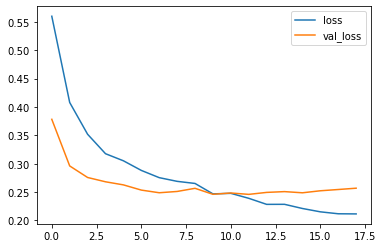

In [65]:
# Check out our train accuracy and validation accuracy over epochs.
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [67]:
y_pred = model.predict(X_test)

In [68]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 1]])

In [69]:
y_pred

array([[2.42604478e-03, 8.17581778e-04, 9.99727190e-01],
       [5.12514869e-03, 2.67184549e-03, 9.99218941e-01],
       [8.37509871e-01, 3.65037411e-01, 2.20223889e-01],
       ...,
       [9.99955535e-01, 2.12566499e-02, 2.93932215e-04],
       [9.95842159e-01, 1.23403154e-01, 9.51821357e-03],
       [3.45198154e-01, 7.35172272e-01, 8.32077444e-01]], dtype=float32)

In [73]:
THRESHOLD = 0.5

y_pred = y_pred  > THRESHOLD
y_pred = y_pred.astype(int)
y_pred_flat = y_pred.astype(int).flatten()

y_true = y_test
y_true_flat = y_true.flatten()

test_acc = sum(y_pred_flat == y_true_flat) / len(y_true_flat)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 91%


In [74]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

array([[[299.,  18.],
        [ 37., 217.]],

       [[318.,  21.],
        [ 25., 207.]],

       [[364.,  13.],
        [ 35., 159.]]], dtype=float32)

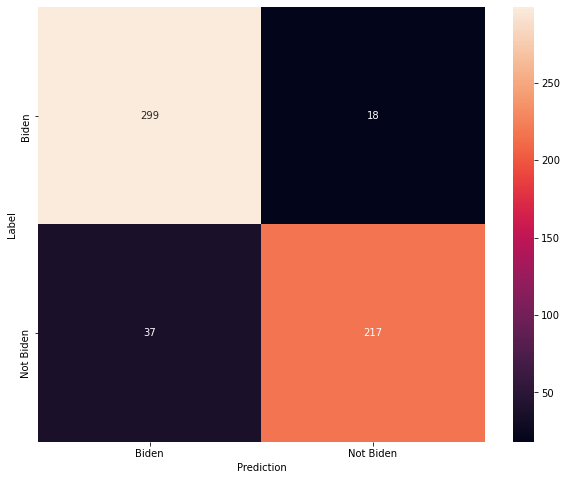

In [75]:
confusion_mtx = result[0]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Biden","Not Biden"],
            yticklabels=["Biden","Not Biden"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

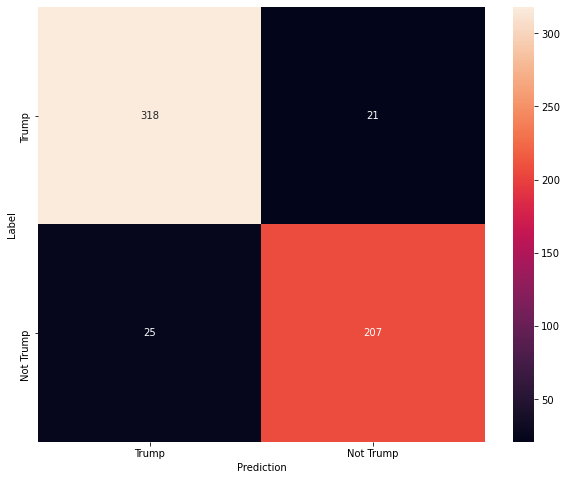

In [76]:
confusion_mtx = result[1]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Trump","Not Trump"],
            yticklabels=["Trump","Not Trump"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

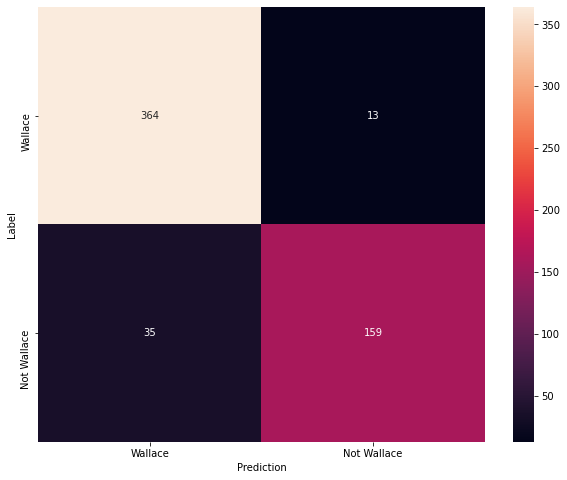

In [77]:
confusion_mtx = result[2]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Wallace","Not Wallace"],
            yticklabels=["Wallace","Not Wallace"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Transfer Learning

Another approach we can use to get highly accurate models with small training datasets is transfer learning. We can find models that have already been trained and transfer the weights the models learnt into our own model. We took advantage of the embeddings provided by [Google VGGish Trained on Youtube 8M Dataset](https://tfhub.dev/google/vggish/1) 

In [78]:
# Load the model.
model = hub.load('https://tfhub.dev/google/vggish/1')



In [79]:
train_files = filenames[:4564]
val_files = filenames[4564: 4564 + 570]
test_files = filenames[-570:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 4564
Validation set size 570
Test set size 570


In [83]:
labels[1,1:]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1])>

In [84]:
def get_embeddings(waveform):
  
  # Run the model, check the output.
  embeddings = model(waveform)
  embeddings.shape.assert_is_compatible_with([None, 128])
  return embeddings

In [85]:
for waveform, label in waveform_ds.take(1):
  label = label
  print(label)
  print(waveform.shape)
  embeddings = get_embeddings(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Embeddings shape:', embeddings.shape)


tf.Tensor([1 0 0], shape=(3,), dtype=int32)
(48000,)
Label: tf.Tensor([1 0 0], shape=(3,), dtype=int32)
Waveform shape: (48000,)
Embeddings shape: (3, 128)


In [100]:
def get_embeddings_and_label_id(audio, label):
  embeddings = get_embeddings(audio)
  
  return embeddings, label

In [101]:
embeddings_ds = waveform_ds.map(
  map_func=get_embeddings_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [102]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_embeddings_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [103]:
train_ds = embeddings_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [104]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [120]:
my_classes = 3
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3, 128), dtype=tf.float32,
                          name='input_embedding'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(my_classes, activation='sigmoid')
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 384)               0         
                                                                 
 dense_28 (Dense)            (None, 1024)              394240    
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_29 (Dense)            (None, 3)                 3075      
                                                                 
Total params: 397,315
Trainable params: 397,315
Non-trainable params: 0
_________________________________________________________________


In [121]:
my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [122]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
72/72 [==============================] - 117s 2s/step - loss: 0.5619 - accuracy: 0.5837 - val_loss: 0.4964 - val_accuracy: 0.6982
Epoch 2/20
72/72 [==============================] - 113s 2s/step - loss: 0.4878 - accuracy: 0.6751 - val_loss: 0.4612 - val_accuracy: 0.7140
Epoch 3/20
72/72 [==============================] - 113s 2s/step - loss: 0.4556 - accuracy: 0.6961 - val_loss: 0.4432 - val_accuracy: 0.7281
Epoch 4/20
72/72 [==============================] - 111s 2s/step - loss: 0.4340 - accuracy: 0.7174 - val_loss: 0.4359 - val_accuracy: 0.7404
Epoch 5/20
72/72 [==============================] - 112s 2s/step - loss: 0.4143 - accuracy: 0.7294 - val_loss: 0.4233 - val_accuracy: 0.7439
Epoch 6/20
72/72 [==============================] - 112s 2s/step - loss: 0.4026 - accuracy: 0.7417 - val_loss: 0.4181 - val_accuracy: 0.7474
Epoch 7/20
72/72 [==============================] - 112s 2s/step - loss: 0.3907 - accuracy: 0.7472 - val_loss: 0.4160 - val_accuracy: 0.7544
Epoch 8/20
72

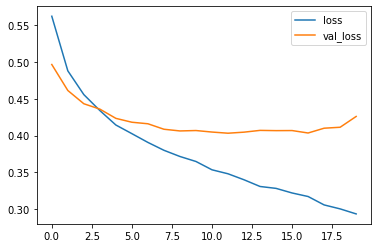

In [123]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [124]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [126]:
THRESHOLD = 0.5

y_pred = my_model.predict(test_audio)
y_pred = y_pred  > THRESHOLD
y_pred = y_pred.astype(int)
y_pred_flat = y_pred.astype(int).flatten()

y_true = test_labels
y_true_flat = test_labels.flatten()

test_acc = sum(y_pred_flat == y_true_flat) / len(y_true_flat)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 83%


In [127]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

array([[[249.,  77.],
        [ 35., 209.]],

       [[299.,  23.],
        [ 69., 179.]],

       [[348.,  29.],
        [ 57., 136.]]], dtype=float32)

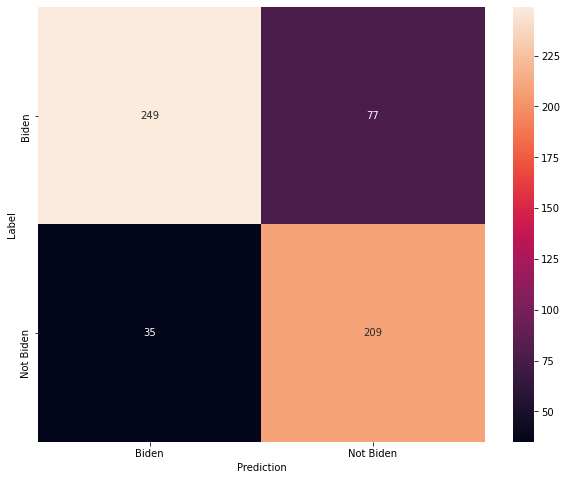

In [128]:
confusion_mtx = result[0]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Biden","Not Biden"],
            yticklabels=["Biden","Not Biden"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

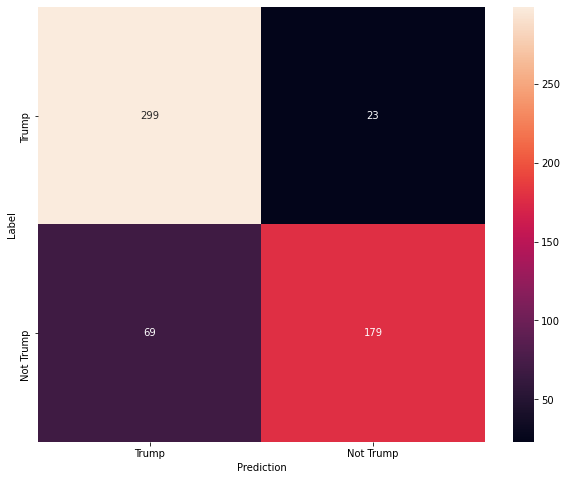

In [129]:
confusion_mtx = result[1]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Trump","Not Trump"],
            yticklabels=["Trump","Not Trump"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

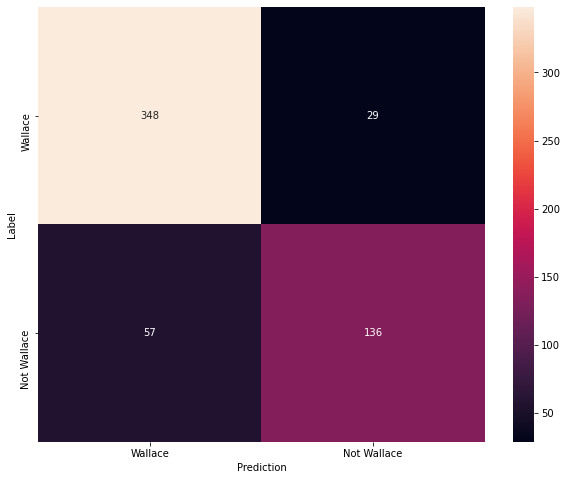

In [130]:
confusion_mtx = result[2]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Wallace","Not Wallace"],
            yticklabels=["Wallace","Not Wallace"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Thoughts

Whilst the idea is wild and not easily implementable, the exercise represents an approach to AI innovation. It is helpful playing with [Kaggle](https://www.kaggle.com/) datasets to sharpen model building skills. The key is experimentation. Scaled experimentation! The deliverable is multiple versions of different models.

To achieve this level of scale a lot of technology will need to be involved. MLOps is emerging as a field to manage scaled AI operations. 